In [1]:
# IMPORTS!!

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
con = duckdb.connect("datasus.db")

# Checando quais tabelas estão disponíveis no banco de dados!!
tables = con.execute("SHOW TABLES").fetchdf()
print("Available tables:")
print(tables)


Available tables:
Empty DataFrame
Columns: [name]
Index: []


In [3]:
# Carregando PO do banco de dados e copiando para um DataFrame(Pandas)
query = "SELECT * FROM PO"
df = con.execute(query).fetchdf()

df = df.copy()

# Fechando a conexão com o banco de dados!!(Mais complicado, usar pandas puro!!)
con.close()
print("Database connection closed.")


print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst 5 rows:")
df.head()


CatalogException: Catalog Error: Table with name PO does not exist!
Did you mean "pg_am"?
LINE 1: SELECT * FROM PO
                      ^

In [4]:
# Vendo DataTypes(Colunas) e Total de Linhas!!

print("Dataset Info:")
print(f"Total records: {len(df):,}")

print("\nData types:")
print(df.dtypes)



Dataset Info:
Total records: 509,434

Data types:
ANO_DIAGN             uint16
ANOMES_DIA            uint32
ANO_TRATAM           float64
ANOMES_TRA           float64
UF_RESID               uint8
MUN_RESID             uint32
UF_TRATAM            float64
MUN_TRATAM           float64
UF_DIAGN               uint8
MUN_DIAG              uint32
TRATAMENTO             uint8
DIAGNOSTIC             uint8
IDADE                float64
SEXO                  object
ESTADIAM             float64
CNES_DIAG             uint32
CNES_TRAT            float64
TEMPO_TRAT            object
CNS_PAC               object
DIAG_DETH             object
DT_DIAG       datetime64[us]
DT_TRAT       datetime64[us]
DT_NASC       datetime64[us]
dtype: object


In [5]:
"""
-> Vamos analisar quantas linhas vazias cada colunas tem!!

-> Cada (Linha(Pessoa), Coluna(Parametro)) Eh chamado de um DataPoint!!

-> Devemos Analisar se a quantidade de DataPoints Vazios eh significativa!! 
e com isso, decidir se devemos remover colunas ou linhas, e quais analises 
poderiam ser feitas!!
"""
print("Total de Linhas: ", len(df))

print("=" * 50)

missing_per_column = df.isnull().sum()  # Contando Valores nao Nulos!!
print("Missing values per column:")
print(missing_per_column)



Total de Linhas:  509434
Missing values per column:
ANO_DIAGN          0
ANOMES_DIA         0
ANO_TRATAM    236279
ANOMES_TRA    236279
UF_RESID           0
MUN_RESID          0
UF_TRATAM     236279
MUN_TRATAM    236279
UF_DIAGN           0
MUN_DIAG           0
TRATAMENTO         0
DIAGNOSTIC         0
IDADE              4
SEXO               0
ESTADIAM       32033
CNES_DIAG          0
CNES_TRAT     236279
TEMPO_TRAT     15473
CNS_PAC       509434
DIAG_DETH          0
DT_DIAG            0
DT_TRAT       236279
DT_NASC            0
dtype: int64


In [6]:
# Vamos Criar remover colunas com todas linhas vazias


print(f"Original dataset shape: {df.shape}")


df = df.drop('CNS_PAC', axis=1)  # Removendo a coluna CNS_PAC (completamente vazia) para todas as Linhas!!

# Limpando as linhas que tem valores nulos nas colunas de tratamento!!
clean_df = df.dropna(subset=['ANO_TRATAM', 'ANOMES_TRA', 'UF_TRATAM', 'MUN_TRATAM', 'CNES_TRAT', 'DT_TRAT'])

print(f"Clean dataset shape (with treatment data): {clean_df.shape}")
print(f"Removed {len(df) - len(clean_df)} rows with missing treatment data")
print(f"Final dataset shape: {clean_df.shape}")


Original dataset shape: (509434, 23)
Clean dataset shape (with treatment data): (273155, 22)
Removed 236279 rows with missing treatment data
Final dataset shape: (273155, 22)


In [7]:
"""
-> Criando uma coluna Nova chamada (Days_To_Treatment)

-> Fazemos isso subtraindo a data de diagnostico da data de tratamento!!
com isso podemos analizar distribuicoes de tempo de tratamento!! e fazer 
analises estatisticas!!

"""

clean_df['days_to_treatment'] = (clean_df['DT_TRAT'] - clean_df['DT_DIAG']).dt.days  #Subtraindo!!

print(f"\nTime to treatment statistics:")   # Vamos fazer alguns cauculos em cima da coluna!!
print(f"Mean days to treatment: {clean_df['days_to_treatment'].mean():.1f}")
print(f"Median days to treatment: {clean_df['days_to_treatment'].median():.1f}")
print(f"Min days to treatment: {clean_df['days_to_treatment'].min()}")
print(f"Max days to treatment: {clean_df['days_to_treatment'].max()}")

# Filter for people treated within 90 days
# Passamos um if para filtrar!! criando um array de booleanos(If, Else)!!
# Com esse array podemos contar, analisar e plotar o numero de pessoas que foram tratadas dentro de 90 dias!!
treated_within_90_days = clean_df[clean_df['days_to_treatment'] <= 90]   
print(f"\nPeople treated within 90 days: {len(treated_within_90_days):,} ({len(treated_within_90_days)/len(clean_df)*100:.1f}%)")



Time to treatment statistics:
Mean days to treatment: 109.8
Median days to treatment: 36.0
Min days to treatment: -90
Max days to treatment: 1896

People treated within 90 days: 196,428 (71.9%)


/tmp/ipykernel_112680/2844335409.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['days_to_treatment'] = (clean_df['DT_TRAT'] - clean_df['DT_DIAG']).dt.days  #Subtraindo!!


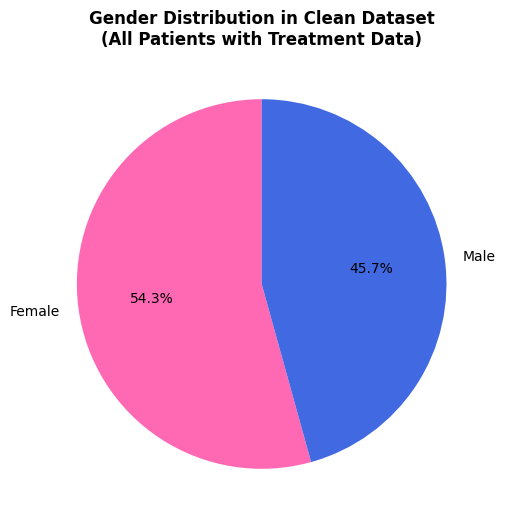

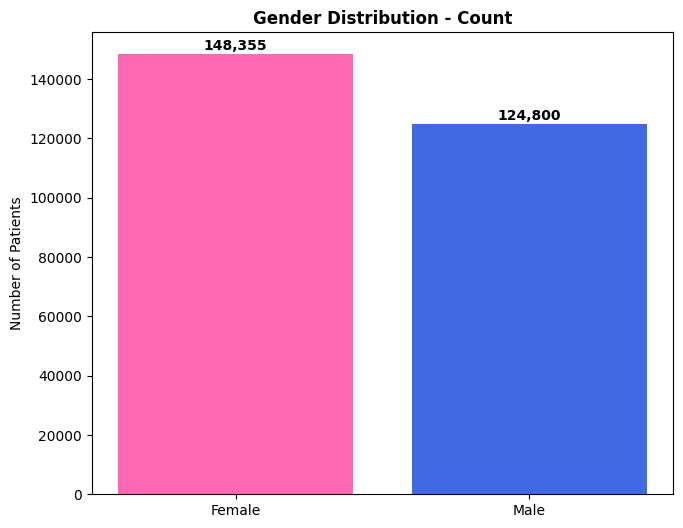

In [8]:
"""
-> Usamos o modulo Matplotlib para criar graficos!!

-> Usamos o modulo Seaborn para criar graficos mais complexos!!

-> Vamos criar alguns graficos com os dados!!
"""

# 1: Distribuicao de Genero!!
gender_counts = clean_df['SEXO'].value_counts()  #  Criando um array com a contagem de cada genero!!
colors = ['#FF69B4', '#4169E1']  # Pink for F, Blue for M

# Grafico 1: Distribuicao de Genero!!(Pizza)
plt.figure(figsize=(7.5, 6))
plt.pie(gender_counts.values, labels=['Female', 'Male'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Gender Distribution in Clean Dataset\n(All Patients with Treatment Data)', 
          fontsize=12, fontweight='bold')
plt.show()


#----------------------------------------------
# Grafico 2: Distribuicao de Genero!!(Barra)
plt.figure(figsize=(7.5, 6))
bars = plt.bar(['Female', 'Male'], gender_counts.values, color=colors)
plt.title('Gender Distribution - Count', fontsize=12, fontweight='bold')
plt.ylabel('Number of Patients')

for bar, count in zip(bars, gender_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')
plt.show()


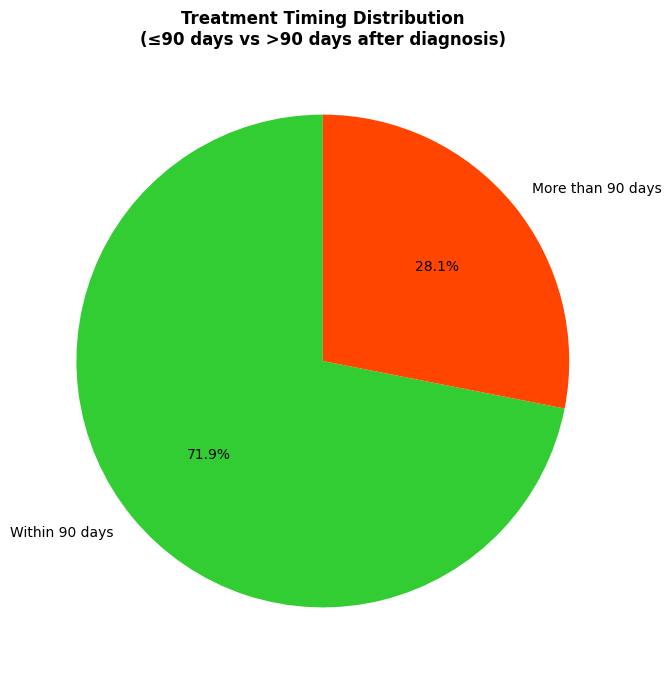


Treatment timing analysis:
Patients treated within 90 days: 196,428 (71.9%)
Patients treated after 90 days: 76,727 (28.1%)

Gender distribution for patients treated within 90 days:
Female: 108,203 (55.1%)
Male: 88,225 (44.9%)


In [12]:
# Vamos agora analisar o tempo de tratamento!!

# Count patients treated within 90 days vs those who weren't
treatment_timing = clean_df['days_to_treatment'] <= 90
within_90_days_count = treatment_timing.sum()
more_than_90_days_count = len(clean_df) - within_90_days_count

# Simple pie chart for treatment timing
labels = ['Within 90 days', 'More than 90 days']
sizes = [within_90_days_count, more_than_90_days_count]
colors_90 = ['#32CD32', '#FF4500']  # Green for within 90, Orange for more than 90

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors_90, startangle=90)
plt.title('Treatment Timing Distribution\n(≤90 days vs >90 days after diagnosis)', 
          fontsize=12, fontweight='bold')
plt.show()

print(f"\nTreatment timing analysis:")
print(f"Patients treated within 90 days: {within_90_days_count:,} ({within_90_days_count/len(clean_df)*100:.1f}%)")
print(f"Patients treated after 90 days: {more_than_90_days_count:,} ({more_than_90_days_count/len(clean_df)*100:.1f}%)")

print(f"\nGender distribution for patients treated within 90 days:")
for gender, count in gender_90_days.items():
    percentage = (count / len(treated_within_90_days)) * 100
    gender_name = 'Female' if gender == 'F' else 'Male'
    print(f"{gender_name}: {count:,} ({percentage:.1f}%)")
